In [1]:
import sys
import os


# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
# building the portfolio with the necessary packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from portfolio import build_portfolio

start_date = datetime.datetime(2024, 4, 1)
end_date = "2024-4-30"

d = {
    0: {"Name": "RELIANCE.NS", "Allocation": 10},
    1: {"Name": "HDFCBANK.NS", "Allocation": 12},
    2: {"Name": "BHARTIARTL.NS", "Allocation": 20},
    3: {"Name": "TCS.NS", "Allocation": 15},
    4: {"Name": "ICICIBANK.NS", "Allocation": 17},
}


pf_allocation = pd.DataFrame.from_dict(d, orient="index")
names = pf_allocation["Name"].values.tolist()

pf = build_portfolio(
    names=names,
    pf_allocation=pf_allocation,
    start_date=start_date,
    end_date=end_date,
    data_api="yfinance",
    # market_index=market_index
)

R = pf.comp_mean_returns()
Sigma = pf.comp_cov()*252

sp_ratio = pf.comp_sharpe()

portfolio = pf.portfolio
data = pf.data


d:\Guided quantum walk for portfolio optimization\main\portfolio.py:263: FutureWarning: YF.download() has changed argument auto_adjust default to True
  res: pd.DataFrame = yfinance.download(names, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\seaborn\matrix.py:306: UserWarning: shading value 'grounded' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


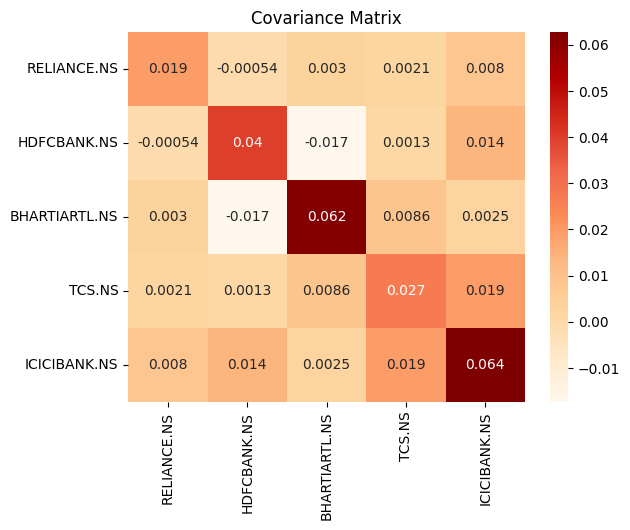

In [3]:
# Calculate the correlation between numerical columns

# Create the heatmap
sns.heatmap(Sigma, annot=True, cmap="OrRd", robust=True, shading='grounded')

plt.title("Covariance Matrix")
plt.show()

In [4]:
# form the qubo problem

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo

gamma = 0.5
B = len(d) // 2
portfolio = PortfolioOptimization(expected_returns=np.array(R), covariances=np.array(Sigma), risk_factor=gamma, budget=B)
qp = portfolio.to_quadratic_program()

qubo_conv = QuadraticProgramToQubo()
qubo_prob = qubo_conv.convert(qp)

cost_op = qubo_prob.to_ising()[0]


In [5]:
# classical solution using numpy minimum eigen solver

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver =  MinimumEigenOptimizer(exact_mes)

result1 = exact_eigensolver.solve(qubo_prob)
print(result1.prettyprint())

objective function value: -2.0121753250696592
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0
status: SUCCESS


In [6]:
# This is quantum solution with the well known QAOA algorithm with the standard qiskit implementation

from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import NELDER_MEAD, COBYLA

cobyla = COBYLA()
nelder_mead = NELDER_MEAD(maxiter=50)
cobyla.set_options(maxiter = 250)
sampler = StatevectorSampler()
qaoa = QAOA(sampler=sampler, optimizer=cobyla, reps=3)
optimizer = MinimumEigenOptimizer(qaoa)
result2 = optimizer.solve(qp)

d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
d:\Guided quantum walk for portfolio optimization\.env\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [7]:
print(result2.prettyprint())

objective function value: -2.01217532506966
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0
status: SUCCESS


In [8]:
# this is locally developed based on quantum walks and referenced qiskit's algorithm structure, quantum algorithm called `guided quantum walk`
from gqw_solver import GQW

# cobyla.set_options(maxiter = 25)

gqw = GQW(sampler = StatevectorSampler(), optimizer=cobyla, reps = 10, time = 2.5)

optimizer = MinimumEigenOptimizer(gqw)
result3 = optimizer.solve(qp)


In [9]:
print(result3.prettyprint())

objective function value: -2.01217532506966
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0
status: SUCCESS


In [10]:
from qiskit.result import QuasiDistribution
def sampling_result(result):

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.items()}
    )
    print("\n----------------- Sampling result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

sampling_result(result3)


----------------- Sampling result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	-2.0122		0.0344
[1 1 0 1 1]	-0.8984		0.0156
[0 1 1 0 0]	-1.8333		0.0128
[0 0 0 0 0]	0.0000		0.0128
[1 1 1 1 0]	-1.4627		0.0043
[0 1 1 0 1]	-2.5654		0.0037
[1 0 1 1 1]	-1.6149		0.0033
[0 1 0 0 1]	-1.2847		0.0009
[1 0 0 0 0]	0.1879		0.0005
[0 0 0 1 0]	0.1681		0.0005
[0 0 1 0 0]	-1.2659		0.0004
[1 0 0 1 0]	0.3582		0.0003
[1 1 1 0 1]	-2.3669		0.0003
[0 1 1 1 1]	-2.3680		0.0002
[0 1 1 1 0]	-1.6553		0.0002
[0 0 1 1 1]	-1.8161		0.0002
[0 1 0 1 0]	-0.3807		0.0002
[1 0 0 0 1]	-0.5528		0.0001
[0 1 0 0 0]	-0.5501		0.0001
[1 0 1 0 1]	-1.8132		0.0001
[1 1 1 0 0]	-1.6429		0.0001
[0 0 0 0 1]	-0.7488		0.0001
[1 0 1 1 0]	-0.8960		0.0000
[0 0 0 1 1]	-0.5614		0.0000
[0 0 1 1 0]	-1.0891		0.0000
[1 1 1 1 1]	-2.1674		0.0000
[1 1 0 1 0]	-0.1912		0.0000
[1 1 0 0 1]	-1.0892		0.0000
[1 0 0 1 1]	-0.3632		0.0000
[1 1 0 0 0]	-0.3627		0.0000
[0 1 0 1 1]	-1.0959		0.000